2018 Aug 8<br>
Making sure I can actually fit synthetic transit data

In [7]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from astropy import units as u

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit
from numpy.random import normal

from lightkurve import KeplerLightCurveFile

from evilmc import evparams, evmodel, convert_Kz
from transit_utils import median_boxcar_filter, bindata, transit_duration, flag_outliers, fit_eclipse_bottom

from PyAstronomy.modelSuite import forTrans as ft

In [55]:
# From Faigler+ (2013 - http://iopscience.iop.org/article/10.1088/0004-637X/771/1/26/meta)
semi = 1./0.221 #± 0.003
print(semi)
imp = 0.944 # ± 0.011
inc = 78.0 # ± 0.2
period = 1.54492875*u.day
Kz_m_per_s = 308. # ± 20.
Kz = convert_Kz(Kz=Kz_m_per_s)

Mp = 2.00*u.jupiterMass # ± 0.26
Rp_over_a = 0.0214 # ± 0.0008
Rp_over_Rs = Rp_over_a*semi
Ms = 1.2*u.solMass # ± 0.2
mass_ratio = Mp.to('kg')/Ms.to('kg')

vsini = 6500.*u.m/u.s # ± 2000
Rs = 1.32*u.solRad #± 0.08
logg = 4.388
m_over_H = -0.033
Omegas = vsini.to('m/s')/Rs.to('m')*period.to('s')

Ts = 6300. # ± 200

Faigler_T0 = (737.49 + 2455000. - 2454833.) % period.to('day').value # ±0.19

coeffs = [0.313, 0.304]
# From https://github.com/nespinoza/limb-darkening
non_lin_coeffs = [0.37915857, 0.62585528, -0.34986866, 0.05968292]

4.52488687783


/Users/bjackson/anaconda2/lib/python2.7/site-packages/transit_utils/transit_utils.py:324: RuntimeWarning: divide by zero encountered in divide
  num_std = abs((copy_data.reshape(-1, 5) - med)/std).flatten()
/Users/bjackson/anaconda2/lib/python2.7/site-packages/transit_utils/transit_utils.py:324: RuntimeWarning: invalid value encountered in divide
  num_std = abs((copy_data.reshape(-1, 5) - med)/std).flatten()
/Users/bjackson/anaconda2/lib/python2.7/site-packages/transit_utils/transit_utils.py:326: RuntimeWarning: invalid value encountered in less
  ind = num_std < num_std_desired


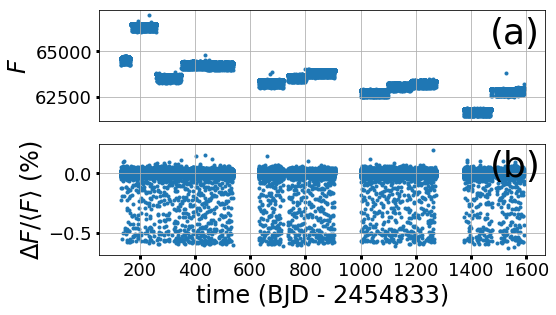

In [74]:
fig = plt.figure(figsize=(8, 4.5))

ax1 = fig.add_subplot(211)
ax1.tick_params(which='both', labelbottom=False, bottom=False)
ax1.tick_params(which='major', axis='y', labelsize=18)
ax1.grid(True)
ax1.set_ylabel("$F$", fontsize=24)
ax1.annotate("(a)", xy=(0.875, 0.7), xytext=(0.875, 0.7), fontsize=36, xycoords='axes fraction')

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.grid(True)
ax2.set_xlabel("time (BJD - 2454833)", fontsize=24)
ax2.set_ylabel("$\Delta F/\\langle F \\rangle$ (%)", fontsize=24)
ax2.tick_params(which='both', labelsize=18)
ax2.annotate("(b)", xy=(0.875, 0.7), xytext=(0.875, 0.7), fontsize=36, xycoords='axes fraction')

time = np.array([])
flux = np.array([])

filtered_time = np.array([])
filtered_flux = np.array([])

# for q in range(0, 18):
ls = glob("/Users/bjackson/research/Active Projects/Variable_Eclipses/mastDownload/Kepler/kplr004570949_lc_Q011111011101110111/*.fits")
#ls = glob("/Users/brian/Documents/research/Variable_Eclipses/mastDownload/Kepler/kplr004570949_lc_Q011111011101110111/*.fits")
for cur_file in ls:
        # PDCSAP_FLUX supposedly takes care of the flux fraction - _Data Processing Handbook_, p. 129
        # https://archive.stsci.edu/kepler/manuals/KSCI-19081-002-KDPH.pdf
#         lc = KeplerLightCurveFile.from_archive('4570949', quarter=q, verbose=False).PDCSAP_FLUX
    lc = KeplerLightCurveFile(cur_file).PDCSAP_FLUX
    lc.remove_nans()
        
    cur_time = lc.time
    cur_flux = lc.flux

    time = np.append(time, cur_time)
    flux = np.append(flux, cur_flux)

    cur_flux = (cur_flux - np.nanmedian(cur_flux))/np.nanmedian(cur_flux)
    window = 2.*period.to('day').value
    del_t = np.median(np.max(cur_time[1:]) - np.max(cur_time[:-1]))
    window_length = int(window/del_t)

    filt = median_boxcar_filter(cur_flux, window_length)

    filtered_time = np.append(filtered_time, cur_time)
    filtered_flux = np.append(filtered_flux, cur_flux - filt)
    
#     except:
#         pass

ind = ~np.isnan(filtered_flux)
filtered_time = filtered_time[ind]
filtered_flux = filtered_flux[ind]

ind = flag_outliers(filtered_flux)
filtered_time = filtered_time[ind]
filtered_flux = filtered_flux[ind]

ax1.scatter(time, flux, marker='.')
ax2.scatter(filtered_time, filtered_flux*100, marker='.')

0.016460023911445708


(0.64, 0.725)

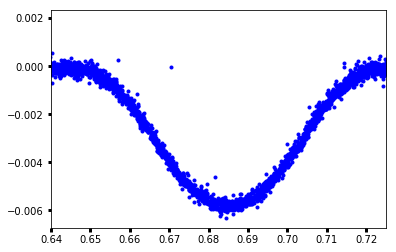

In [101]:
folded_time = filtered_time % period.to('day').value
plt.plot(folded_time, filtered_flux, 'b.')

ind = (folded_time < 0.6) | (folded_time > 0.8)
Kepler_76_sig = mad(filtered_flux[ind])
print(Kepler_76_sig/Rp_over_Rs**2)
plt.xlim([0.64, 0.725])

In [79]:
def fit_signal(time, T0, a, p, i, supersample_factor=5, exp_time=30./60./24., subtract_one=False):
    model = ft.MandelAgolLC(orbit="circular", ld="quad")

    # Set parameters
    model["per"] = period.to('day').value
    model["i"] = i
    model["a"] = a
    model["T0"] = T0
    model["p"] = p
    model["linLimb"] = coeffs[0]
    model["quadLimb"] = coeffs[1]
    model["b"] = 0.

    # Consider finite exposure time
    time_supersample = time
    if(supersample_factor > 1):
        time_offsets = np.linspace(-exp_time/2., exp_time/2., supersample_factor)
        time_supersample = (time_offsets + time.reshape(time.size, 1)).flatten()
    
    ret = model.evaluate(time_supersample)
    
    if(supersample_factor > 1):
        ret = np.mean(ret.reshape(-1, supersample_factor), axis=1)
        
    if(subtract_one):
        ret -= 1.
        
    return ret

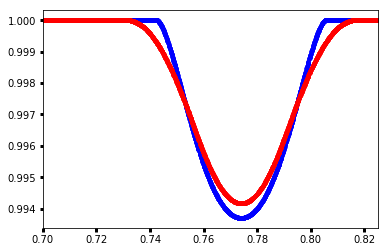

In [65]:
# Make synthetic transit
y = fit_signal(folded_time, np.median(folded_time), semi, Rp_over_Rs, inc, supersample_factor=1)

# Let's see what happened ...
plt.plot(folded_time, y, 'b.')
plt.xlim([0.7, 0.825])

y = fit_signal(folded_time, np.median(folded_time), semi, Rp_over_Rs, inc)

# Let's see what happened ...
plt.plot(folded_time, y, 'r.')

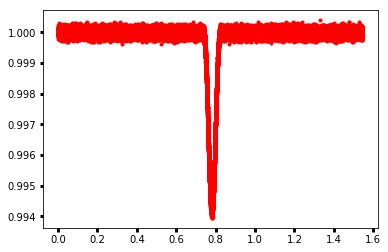

In [102]:
y = fit_signal(folded_time, np.median(folded_time), semi, Rp_over_Rs, inc)

# Making the inclination large
#y = fit_signal(folded_time, np.median(folded_time), semi, Rp_over_Rs, 90.)

sig = Rp_over_Rs**2/100.
noisy_y = y + np.random.normal(size=y.shape, scale=sig)
plt.plot(folded_time, noisy_y, 'r.')

------------------------------------
Parameters for Component: Occultquad
------------------------------------
Parameter:        a  Occultquad, [       a], value:      4.52489, free: False, restricted: False, related: False
Parameter:        b  Occultquad, [       b], value:            0, free: False, restricted: False, related: False
Parameter: quadLimb  Occultquad, [quadLimb], value:        0.304, free: False, restricted: False, related: False
Parameter:        i  Occultquad, [       i], value:           78, free: False, restricted: False, related: False
Parameter:       T0  Occultquad, [      T0], value:     0.774023, free: False, restricted: False, related: False
Parameter:        p  Occultquad, [       p], value:    0.0968326, free: False, restricted: False, related: False
Parameter:      per  Occultquad, [     per], value:      1.54493, free: False, restricted: False, related: False
Parameter:  linLimb  Occultquad, [ linLimb], value:        0.313, free: False, restricted: False, 

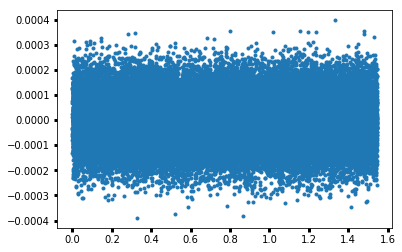

In [103]:
time = folded_time
flux = noisy_y

initial_guess = [0.7, 3., Rp_over_Rs, inc]

popt, pcov = curve_fit(fit_signal, time, flux,
                       p0=initial_guess, sigma=np.ones_like(time)*Rp_over_Rs**2/10.,
                       bounds=([0.7, 2., 0., 70.], [0.8, 6., 0.2, 95.]))

ma.parameterSummary()
print(initial_guess)
print(popt, np.sqrt(pcov.diagonal()))

#plt.errorbar(time, flux - fit_signal(time, *popt), err)
# plt.plot(time, fit_signal(time, *popt))

# plt.plot(time, flux, marker='.', ls='')
# plt.plot(time, fit_signal(time, *popt), marker='.', ls='')
plt.plot(time, flux - fit_signal(time, *popt), marker='.', ls='')

[0.7, 3.0, 0.09683257918552035, 78.0]
(array([ 0.68498101,  5.27009361,  0.08540733, 80.13985404]), array([2.13804511e-05, 5.02212613e-02, 4.35713465e-04, 1.24324723e-01]))


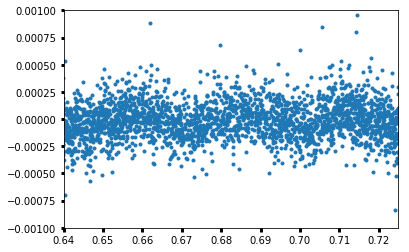

In [94]:
def cur_fit_signal(time, T0, a, p, i):
    return fit_signal(time, T0, a, p, i, subtract_one=True)

# Let's try with some real data
time = folded_time
flux = filtered_flux

initial_guess = [0.7, 3., Rp_over_Rs, inc]

popt, pcov = curve_fit(cur_fit_signal, time, flux,
                       p0=initial_guess, sigma=np.ones_like(time)*Kepler_76_sig,
                       bounds=([0.6, 2., 0., 70.], [0.8, 6., 0.2, 95.]))

print(initial_guess)
print(popt, np.sqrt(pcov.diagonal()))

# plt.plot(time, flux, marker='.', ls='')
# plt.plot(time, cur_fit_signal(time, *popt), marker='.', ls='')
plt.plot(time, flux - cur_fit_signal(time, *popt), marker='.', ls='')
plt.ylim([-0.001, 0.001])
plt.xlim([0.64, 0.725])

T0 = popt[0]

(0.64, 0.725)

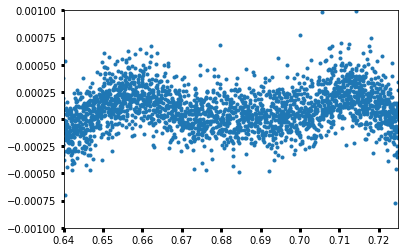

In [96]:
# How about just use the parameters that Faigler did?
plt.plot(folded_time, flux - cur_fit_signal(folded_time, T0, semi, Rp_over_Rs, inc), marker='.', ls='')
plt.ylim([-0.001, 0.001])
plt.xlim([0.64, 0.725])

(0.64, 0.725)

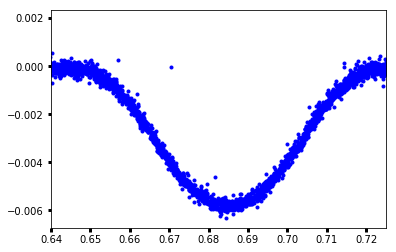

In [93]:
plt.plot(folded_time, filtered_flux, 'b.')
plt.xlim([0.64, 0.725])